<a href="https://colab.research.google.com/github/Apidwalin/-DESKTOP-9QGAS69-tensorflow1/blob/Apidwalin-patch-1/deepmac_colab_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Novel class segmentation demo with Deep-MAC

Welcome to the Novel class segmentation (with Deep-MAC) demo --- this colab loads a Deep-MAC model and tests it interactively with user-specified boxes. Deep-MAC was only trained to detect and segment COCO classes, but generalizes well when segmenting within user-specified boxes of unseen classes.

Estimated time to run through this colab (with GPU): 10-15 minutes.
Note that the bulk of this time is in installing Tensorflow and downloading
the checkpoint then running inference for the first time.  Once you've done
all that, running on new images is very fast.

# Prerequisites

Please change runtime to GPU.

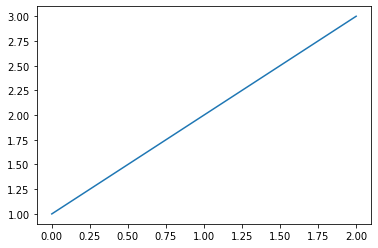

In [1]:
import numpy as np

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.pyplot as plt

plt.plot([1, 2, 3])

canvas = plt.gcf().canvas

agg = canvas.switch_backends(FigureCanvasAgg)
agg.draw()
X = np.asarray(agg.buffer_rgba())

# Pass off to PIL.
from PIL import Image
im = Image.fromarray(X)

# Uncomment this line to display the image using ImageMagick's `display` tool.
# im.show()

# Installation and Imports

This takes 3-4 minutes.

In [2]:
!pip install -U --pre tensorflow=="2.2.0"

import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models


     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 2.9MB 41.8MB/s 
     |████████████████████████████████| 460kB 46.1MB/s 
     |████████████████████████████████| 3.0MB 28.2MB/s 
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0
Cloning into 'models'...
remote: Enumerating objects: 2720, done.
remote: Counting objects: 100% (2720/2720), done.
remote: 

In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1657639 sha256=c894e8d4d88ac464d2ad227e6e2a7dfda2375b1e6eb7b80fcb69d3a9d26e6195
  Stored in directory: /tmp/pip-ephem-wheel-cache-p_cpk29m/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=acdb738c48aab8821370496c0db959a89a211f809dbf37e8877a24fbc0fcf61e
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78545 sha256=cc7ea0552876ff51db1466e4470e5dcc8b812a73cc9f34bc750dbdca803bc875
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=b403a74495228a4d4e5ac53281b8bcaf1b1e98e03f3abbbaba73

ERROR: multiprocess 0.70.12.2 has requirement dill>=0.3.4, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.30.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [4]:
import glob
import io
import logging
import os
import random
import warnings

import imageio
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import matplotlib
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from object_detection.utils import colab_utils
from object_detection.utils import ops
from object_detection.utils import visualization_utils as viz_utils
from PIL import Image, ImageDraw, ImageFont
import scipy.misc
from six import BytesIO
from skimage import color
from skimage import transform
from skimage import util
from skimage.color import rgb_colors
import tensorflow as tf

%matplotlib inline

COLORS = ([rgb_colors.cyan, rgb_colors.orange, rgb_colors.pink,
           rgb_colors.purple, rgb_colors.limegreen , rgb_colors.crimson] +
          [(color) for (name, color) in color.color_dict.items()])
random.shuffle(COLORS)

logging.disable(logging.WARNING)


def read_image(path):
  """Read an image and optionally resize it for better plotting."""
  with tf.io.gfile.GFile(path, 'rb') as f:
    img = Image.open(f)
    return np.array(img, dtype=np.uint8)


def resize_for_display(image, max_height=600):
  height, width, _ = image.shape
  width = int(width * max_height / height)
  with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    return util.img_as_ubyte(transform.resize(image, (height, width)))


def get_mask_prediction_function(model):
  """Get single image mask prediction function using a model."""

  @tf.function
  def predict_masks(image, boxes):
    height, width, _ = image.shape.as_list()
    batch = image[tf.newaxis]
    boxes = boxes[tf.newaxis]

    detections = model(batch, boxes)
    masks = detections['detection_masks']

    return ops.reframe_box_masks_to_image_masks(masks[0], boxes[0],
                                                height, width)

  return predict_masks


def plot_image_annotations(image, boxes, masks, darken_image=0.5):
  fig, ax = plt.subplots(figsize=(16, 12))
  ax.set_axis_off()
  image = (image * darken_image).astype(np.uint8)
  ax.imshow(image)

  height, width, _ = image.shape

  num_colors = len(COLORS)
  color_index = 0

  for box, mask in zip(boxes, masks):
    ymin, xmin, ymax, xmax = box
    ymin *= height
    ymax *= height
    xmin *= width
    xmax *= width

    color = COLORS[color_index]
    color = np.array(color)
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2.5, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    mask = (mask > 0.5).astype(np.float32)
    color_image = np.ones_like(image) * color[np.newaxis, np.newaxis, :]
    color_and_mask = np.concatenate(
        [color_image, mask[:, :, np.newaxis]], axis=2)

    ax.imshow(color_and_mask, alpha=0.5)

    color_index = (color_index + 1) % num_colors

  return ax

# Load Deep-MAC Model

This can take up to 5 minutes.

In [5]:
print('Downloading and untarring model')
!wget http://download.tensorflow.org/models/object_detection/tf2/20210329/deepmac_1024x1024_coco17.tar.gz
!cp deepmac_1024x1024_coco17.tar.gz models/research/object_detection/test_data/
!tar -xzf models/research/object_detection/test_data/deepmac_1024x1024_coco17.tar.gz
!mv deepmac_1024x1024_coco17 models/research/object_detection/test_data/
model_path = 'models/research/object_detection/test_data/deepmac_1024x1024_coco17/saved_model'

print('Loading SavedModel')
model = tf.keras.models.load_model(model_path)
prediction_function = get_mask_prediction_function(model)

--2021-06-25 02:46:20--  http://download.tensorflow.org/models/object_detection/tf2/20210329/deepmac_1024x1024_coco17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.99.128, 2607:f8b0:400e:c0a::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.99.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1792904062 (1.7G) [application/x-tar]
Saving to: ‘deepmac_1024x1024_coco17.tar.gz’

deepmac_1024x1024_c 100%[===================>]   1.67G   124MB/s    in 13s     

2021-06-25 02:46:34 (129 MB/s) - ‘deepmac_1024x1024_coco17.tar.gz’ saved [1792904062/1792904062]

Loading SavedModel


# Load image

In [6]:
image_path = 'models/research/object_detection/test_images/image3.jpg'
image = read_image(image_path)

# Annotate an image with one or more boxes

This model is trained on COCO categories, but we encourage you to try segmenting
anything you want!

Don't forget to hit **submit** when done.

In [7]:
display_image = resize_for_display(image)

boxes_list = []
colab_utils.annotate([display_image], boxes_list)

<IPython.core.display.Javascript object>

# In case you didn't want to label...

Run this cell only if you didn't annotate anything above and would prefer to just use our preannotated boxes. Don't forget to uncomment.



In [8]:
# boxes_list = [np.array([[0.000, 0.160, 0.362, 0.812],
#                         [0.340, 0.286, 0.472, 0.619],
#                         [0.437, 0.008, 0.650, 0.263],
#                         [0.382, 0.003, 0.538, 0.594],
#                         [0.518, 0.444, 0.625,0.554]], dtype=np.float32)]

# Visualize mask predictions

In [9]:
%matplotlib inline

boxes = boxes_list[0]
masks = prediction_function(tf.convert_to_tensor(image),
                            tf.convert_to_tensor(boxes, dtype=tf.float32))
plot_image_annotations(image, boxes, masks.numpy())
plt.show()

IndexError: ignored